In [2]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.preprocessing import LabelEncoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import os
data_root = 'data/afhq'

data = []

for split in os.listdir(data_root):
    for animal in os.listdir(f'{data_root}/{split}'):
        for img in os.listdir(f'{data_root}/{split}/{animal}'):
            data.append([f'{data_root}/{split}/{animal}/{img}', animal])

data[-1]

['data/afhq/val/wild/pixabay_wild_001224.jpg', 'wild']

In [4]:
data_df = pd.DataFrame(data, columns=["image_path", "labels"])
data_df.head()

,image_path,labels
0,data/afhq/train/cat/flickr_cat_000002.jpg,cat
1,data/afhq/train/cat/flickr_cat_000003.jpg,cat
2,data/afhq/train/cat/flickr_cat_000004.jpg,cat
3,data/afhq/train/cat/flickr_cat_000005.jpg,cat
4,data/afhq/train/cat/flickr_cat_000006.jpg,cat


In [5]:
data_df.labels.unique()

array(['cat', 'dog', 'wild'], dtype=object)

In [6]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

train.shape, test.shape, val.shape

((11291, 2), (2419, 2), (2420, 2))

In [7]:
encoder = LabelEncoder()
encoder.fit(data_df.labels)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [8]:
data_df.iloc[0].values

array(['data/afhq/train/cat/flickr_cat_000002.jpg', 'cat'], dtype=object)

In [17]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(encoder.transform(self.dataframe.labels)).long().to(device)
    
    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image).to(device)
        
        return image, label

In [18]:
train_dataset = CustomImageDataset(train, transform)
test_dataset = CustomImageDataset(test, transform)
val_dataset = CustomImageDataset(val, transform)

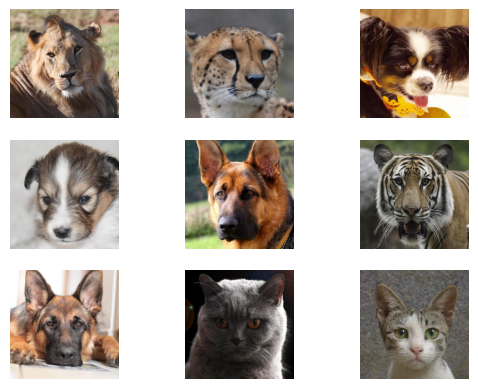

In [19]:
r, c = 3, 3
fig, ax = plt.subplots(r, c)

for i in range(r):
    for j in range(c):
        image = Image.open(data_df.sample(n = 1).iloc[0, 0]).convert('RGB')
        ax[i, j].imshow(image)
        ax[i, j].axis('off')

plt.show()

In [20]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
import torch
import torch.nn as nn

class Net(nn.Module):
    """
    A simple neural network with three convolutional layers,
    followed by a linear layer to classify images.

    Attributes:
        conv1 (nn.Conv2d): The first convolutional layer.
        conv2 (nn.Conv2d): The second convolutional layer.
        conv3 (nn.Conv2d): The third convolutional layer.
        pool (nn.MaxPool2d): A max pooling layer.
        relu (nn.ReLU): A ReLU activation function.
        flatten (nn.Flatten): A flattening layer.
        linear1 (nn.Linear): The first linear layer.
        output (nn.Linear): The output linear layer.
    """

    def __init__(self):
        """
        Initializes the Net class.

        Note:
            This method is called once at construction time.
        """
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Activation function
        self.relu = nn.ReLU()

        # Flattening layer
        self.flatten = nn.Flatten()

        # Linear layers
        self.linear1 = nn.Linear((128 * 16 * 16), 128)
        self.output = nn.Linear(128, 10)  # Assuming data_df.labels.nunique() is 10

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor.
        """
        x = self.conv1(x)    # (128, 128, 3) -> (128, 128, 32)
        x = self.relu(x)     # (128, 128, 32) -> (128, 128, 32)
        x = self.pool(x)     # (128, 128, 32) -> (64, 64, 32)

        x = self.conv2(x)    # (64, 64, 32) -> (64, 64, 64)
        x = self.relu(x)     # (64, 64, 64) -> (64, 64, 64)
        x = self.pool(x)     # (64, 64, 64) -> (32, 32, 64)

        x = self.conv3(x)    # (32, 32, 64) -> (32, 32, 128)
        x = self.relu(x)     # (32, 32, 128) -> (32, 32, 128)
        x = self.pool(x)     # (32, 32, 128) -> (16, 16, 128)

        x = self.flatten(x)  # (16, 16, 128) -> (32768, )
        x = self.linear1(x)  # (32768, ) -> (128, )
        x = torch.relu(x)    # (128, ) -> (128, )
        x = self.output(x)   # (128, ) -> (10, )

        return x

In [14]:
from torchsummary import summary

model = Net().to(device)
summary(model, input_size=(3, 128, 128), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
              ReLU-8          [-1, 128, 32, 32]               0
         MaxPool2d-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                   [-1, 10]           1,290
Total params: 4,288,970
Trainable params: 4,288,970
Non-trainable params: 0
---------------------------

In [24]:
import time

start_time = time.time()

epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
epoch_times = []

for epoch in range(epochs):
    train_loss = train_acc = 0
    val_loss = val_acc = 0

    for images, labels in train_loader:
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        train_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        for images_val, labels_val in val_loader:
            outputs = model(images_val)
            val_loss += loss_fn(outputs, labels_val).item()

            val_acc += (torch.argmax(outputs, dim=1) == labels_val).sum().item()

    train_losses.append(round(train_loss / 1000, 4))
    val_losses.append(round(val_loss / 1000, 4))

    train_accuracies.append(round((train_acc / len(train_dataset)) * 100, 4))
    val_accuracies.append(round((val_acc / len(val_dataset)) * 100, 4))

    elapsed_time = time.time() - start_time
    epoch_times.append(elapsed_time / (epoch + 1))
    
    
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Training Accuracy: {train_accuracies[-1]}, Validation Accuracy: {val_accuracies[-1]}, Elapsed Time per epoch: {(elapsed_time / (epoch + 1)):.4f} seconds")

end_time = time.time()
print("Training completed in {:.2f} seconds".format(end_time - start_time))


Epoch 1/5, Training Loss: 0.0343, Validation Loss: 0.018, Training Accuracy: 98.3261, Validation Accuracy: 96.3223, Elapsed Time per epoch: 162.9988 seconds
Epoch 2/5, Training Loss: 0.0241, Validation Loss: 0.0232, Training Accuracy: 98.8221, Validation Accuracy: 95.9504, Elapsed Time per epoch: 162.2592 seconds
Epoch 3/5, Training Loss: 0.016, Validation Loss: 0.0199, Training Accuracy: 99.2472, Validation Accuracy: 96.7769, Elapsed Time per epoch: 158.7134 seconds
Epoch 4/5, Training Loss: 0.0122, Validation Loss: 0.0291, Training Accuracy: 99.3446, Validation Accuracy: 95.3306, Elapsed Time per epoch: 157.8816 seconds
Epoch 5/5, Training Loss: 0.0118, Validation Loss: 0.0315, Training Accuracy: 99.4597, Validation Accuracy: 94.9174, Elapsed Time per epoch: 157.8688 seconds
Training completed in 789.34 seconds


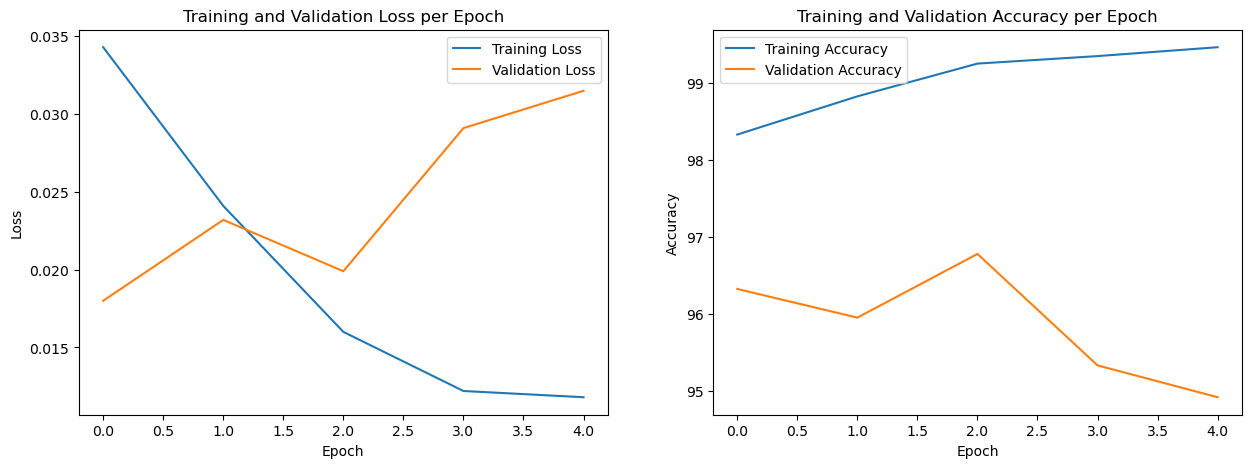

Average time taken per epoch: 159.9444 seconds


In [31]:
# Plot training and validation loss
import matplotlib.pyplot as plt

_, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(range(epochs), train_losses, label='Training Loss')
axs[0].plot(range(epochs), val_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss per Epoch')
axs[0].legend()



axs[1].plot(range(epochs), train_accuracies, label='Training Accuracy')
axs[1].plot(range(epochs), val_accuracies, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy per Epoch')
axs[1].legend()

plt.show()

# Print average time taken per epoch
average_time_per_epoch = sum(epoch_times) / len(epoch_times)
print(f"Average time taken per epoch: {average_time_per_epoch:.4f} seconds")

In [35]:
# Compute the loss and accuracy of the model on the test set
test_loss = test_acc = 0
test_predicted, test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        test_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()
        test_loss += loss_fn(outputs, labels).item()

        test_predicted.extend(torch.argmax(outputs, dim=1).tolist())
        test_labels.extend(labels.tolist())


print(f"Test loss: {test_loss / 1000:.4f}, Test accuracy: {(test_acc / len(test_dataset)) * 100:.4f}%")

Test loss: 0.0413, Test accuracy: 94.3365%


Accuracy of 'cat': 94.40%
Accuracy of 'dog': 89.62%
Accuracy of 'wild': 99.10%
Overall test accuracy: 94.38%


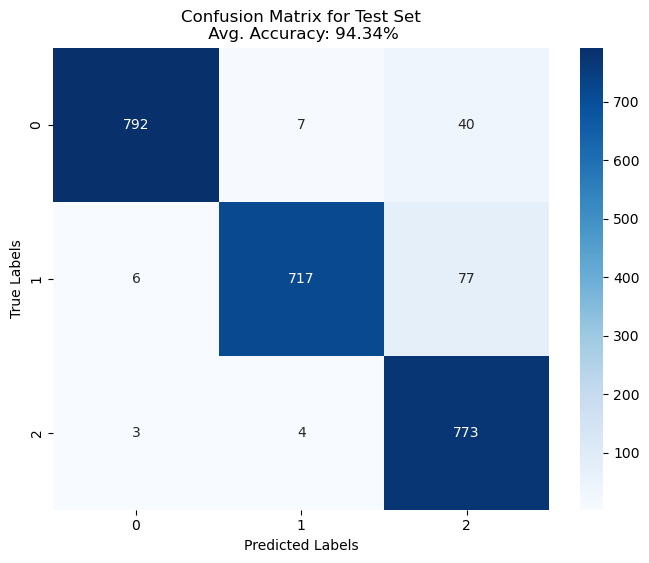

In [46]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Compute test accuracy across each class
num_classes = data_df.labels.nunique()
test_class_accuracy = []
for i in range(num_classes):
    # Get the number of correct predictions for each class
    total_correct = sum([test_predicted[j] == test_labels[j] for j in range(len(test_labels)) if test_labels[j] == i])

    # Count how many labels for the current class are present in test_loader
    num_class_labels = sum([label == i for label in test_loader.dataset.labels])

    test_class_accuracy.append(total_correct / num_class_labels * 100)
    print(f"Accuracy of '{encoder.inverse_transform([i])[0]}': {test_class_accuracy[i]:.2f}%")

# Compute overall test accuracy
test_accuracy = sum(test_class_accuracy) / len(test_class_accuracy)
print(f"Overall test accuracy: {test_accuracy:.2f}%")


conf_mat = confusion_matrix(test_labels, test_predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix for Test Set\n Avg. Accuracy: {((np.array(test_predicted) == np.array(test_labels)).sum() / len(test_labels)) * 100:.2f}%')
plt.show()